In [1]:
!nvidia-smi

Sat Dec 11 13:29:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 260 (delta 120), reused 225 (delta 95), pack-reused 0
Receiving objects: 100% (260/260), 53.15 MiB | 29.37 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=1d6d6047c9ed4b54928beb2b65b45bef897f9f5a7dbd890f56ccebaf8ab84243
  Stored in directory: /tmp/pip-ephem-wheel-cache-tr6cam1w/wheels/55/59/29/0fb1c63565215

In [3]:
from dul_2021.utils.hw4_utils import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta
from torch.distributions import MultivariateNormal
from tqdm.notebook import tqdm

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook
from typing import Tuple, Union, List

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


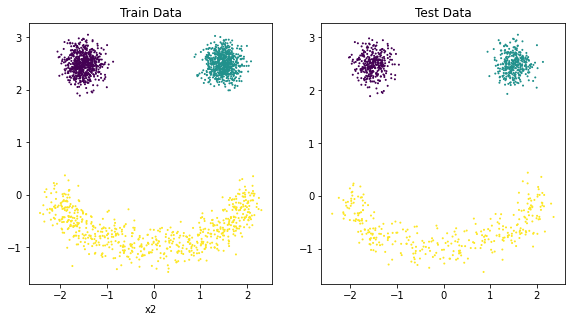

Dataset 2


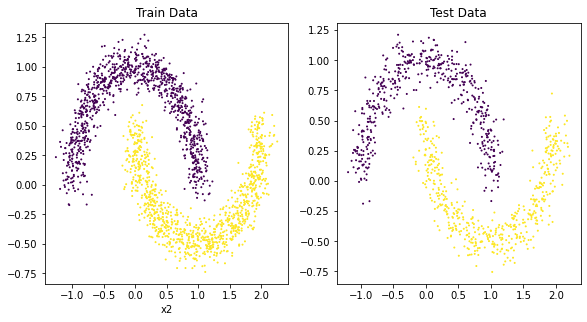

In [7]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [8]:
class CNFlow(nn.Module): 
    def __init__(self, input_dim: int, hidden_dim: int, width: int,
                 t0: float = 0.0, t1: float = 10.0, tol: float = 1e-5): 
        super().__init__()
        self.input_dim = input_dim
        self.width = width

        self.t0 = t0
        self.t1 = t1

        self.model = nn.Sequential(
            nn.Linear(1, hidden_dim), 
            nn.Tanh(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.Tanh(), 
            nn.Linear(hidden_dim, width * (2 * input_dim + 1))
        )
        
        self.tanh = nn.Tanh()

        self.base_dist =  MultivariateNormal(
            torch.zeros(input_dim, dtype=torch.float32, device=device),
            torch.eye(input_dim, dtype=torch.float32, device=device))
        
    def _u_omega_b(self, t: torch.Tensor) -> Tuple[torch.Tensor, ...]: 
        out = self.model(t.view(1, -1).float()).squeeze()

        block_size = self.width * self.input_dim 

        u = out[:block_size].view(self.width, 1, self.input_dim)
        omega = out[block_size:(2 * block_size)].view(self.width, self.input_dim, 1)
        b = out[(2 * block_size):].view(self.width, 1, 1)

        return u, omega, b

    def _dz_dt(self, t: torch.Tensor, zt: torch.Tensor) -> torch.Tensor: 
        # dz_dt = u * tanh(omega ^ T * z(t) + b)
        u, omega, b = self._u_omega_b(t)
        zt = zt.unsqueeze(0).repeat(self.width, 1, 1)
        tanh = torch.tanh(zt.matmul(omega) + b)
        dz_dt = tanh.matmul(u).mean(dim=0)
        return dz_dt

    def _dlog_p_dt(self, f: torch.Tensor, zt: torch.Tensor) -> torch.Tensor: 
        m_trace = torch.zeros(len(zt), dtype=torch.float32, device=device)

        for i in range(self.input_dim):
            m_trace -= torch.autograd.grad(f[:, i].sum(), zt, 
                                           create_graph=True)[0][:, i]

        return m_trace.reshape(len(zt), 1)

    @torch.enable_grad()
    def forward(self, t: torch.Tensor, 
                input: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]: 
        z0, _ = input 
        z0.requires_grad_(True)
        dz_dt = self._dz_dt(t, z0)
        dlog_p_dt = self._dlog_p_dt(dz_dt, z0)
        return dz_dt, dlog_p_dt

    def flow(self, z0: torch.Tensor) -> torch.Tensor: 
        time = torch.tensor([self.t0, self.t1], dtype=torch.float32, device=device)
        start = torch.zeros((len(z0), 1), dtype=torch.float32, device=device)

        z_t, log_p_z = odeint(self, (z0, start), time, 
                              atol=1e-5, rtol=1e-5, method="dopri5")
        
        return z_t[-1], -log_p_z[-1]
        
    def log_prob(self, x: torch.Tensor) -> torch.Tensor: 
        z, log_det = self.flow(x)
        log_p_z = self.base_dist.log_prob(z).reshape(len(x), 1)
        return log_p_z + log_det

    def loss(self, x: torch.Tensor) -> torch.Tensor: 
        return -self.log_prob(x).mean()

    def test(self, test_loader: data.DataLoader) -> float: 
        self.eval()

        total_loss, n_elements = 0., 0

        with torch.no_grad():
            for batch in test_loader:
                loss = self.loss(batch.to(device).float())
                total_loss += len(batch) * loss.item()
                n_elements += len(batch)

        return total_loss / n_elements

    def fit(self, train_data: np.ndarray, test_data: np.ndarray, 
            epochs: int = 20, lr: float = 1e-3, batch_size: int = 128) -> Tuple[np.ndarray, np.ndarray]: 
        train_loader = data.DataLoader(train_data, batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size, shuffle=False)
          
        train_losses, test_losses = [], []

        optimizer = opt.Adam(self.parameters(), lr=lr)
        test_losses.append(self.test(test_loader))

        for _ in tqdm(range(epochs)): 
            self.train()
            total_loss, n_elements = 0., 0

            for batch in train_loader:
                loss = self.loss(batch.to(device).float())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += len(batch) * loss.item()
                n_elements += len(batch)

            train_losses.append(total_loss / n_elements)
            test_losses.append(self.test(test_loader))
          
        return train_losses, test_losses

    def get_probabilities(self, data: np.ndarray) -> np.ndarray:
        self.eval()

        data = torch.tensor(data, dtype=torch.float32, device=device)

        with torch.no_grad():
            log_prob = self.log_prob(data)

        return log_prob.exp().cpu().numpy()

    def get_latents(self, data: np.ndarray) -> np.ndarray:
        self.eval()

        data = torch.tensor(data, dtype=torch.float32, device=device)

        with torch.no_grad():
            z, _ = self.flow(data)

        return z.cpu().numpy()

In [ ]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    model = CNFlow(input_dim=2, hidden_dim=32, width=5).to(device)
    train_losses, test_losses = model.fit(train_data, test_data, epochs=100)

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]

    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = model.get_probabilities(mesh_xs)
    latents = model.get_latents(train_data)

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 1.4073


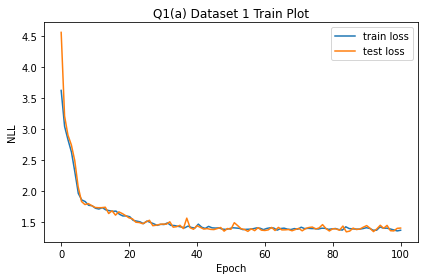

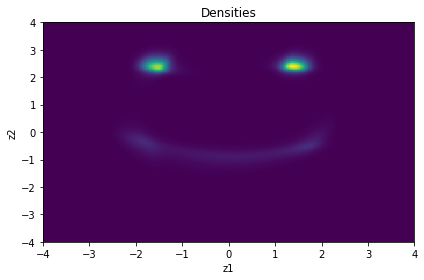

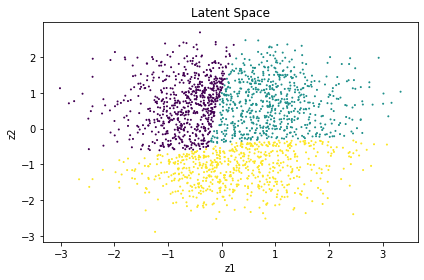

In [ ]:
q1_save_results(1, 'a', q1)

  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 1.2181


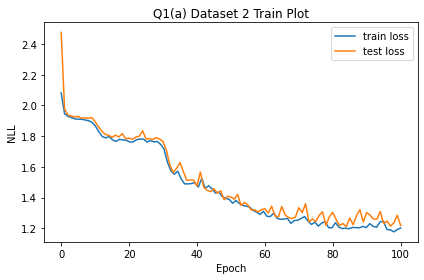

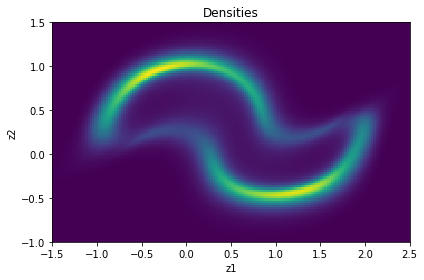

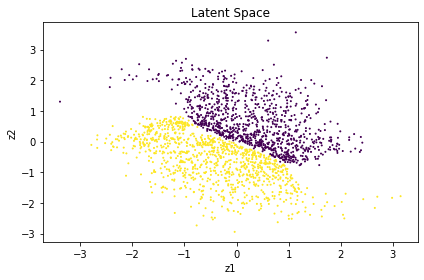

In [ ]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [44]:
class HCNFlow(CNFlow): 
    def __init__(self, input_dim: int, hidden_dim: int, width: int,
                 t0: float = 0.0, t1: float = 10.0): 
        super().__init__(input_dim, hidden_dim, width, t0, t1)
        self.v = None

    def flow(self, z0: torch.Tensor) -> torch.Tensor: 
        self.v = 2 * torch.randint(0, 2, z0.shape, dtype=torch.float32, device=device) - 1
        time = torch.tensor([self.t0, self.t1], dtype=torch.float32, device=device)
        start = torch.zeros((len(z0), 1), dtype=torch.float32, device=device)
        z_t, log_p_z = odeint(self, (z0, start), time, 
                              atol=1e-5, rtol=1e-5, method="dopri5")
        
        return z_t[-1], -log_p_z[-1]

    def _dlog_p_dt(self, f: torch.Tensor, zt: torch.Tensor) -> torch.Tensor: 
        A = torch.autograd.grad((self.v * f).sum(dim=(1, 0)), zt, create_graph=True)[0]
        trace = (A * self.v).sum(dim=1).view(len(zt), 1)
        return -trace

In [45]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """
    
    model = HCNFlow(input_dim=10, hidden_dim=32, width=5).to(device)
    train_losses, test_losses = model.fit(train_data, test_data, epochs=100)
    return train_losses, test_losses

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 11.6521


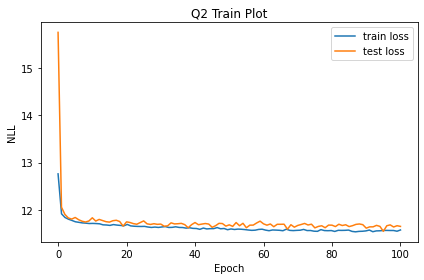

In [46]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)